1. We will consider the prices between 0 and 1
2. We will consider amount of stocks between 0 and 1.
3. Reward at the terminal state will be calculated.

## Consider following variabes as state of the system

Our state is comprised of price, stocks available, last dark pool execution, last dark pool order, time

$p_t = $ price in market order at $t$

$ X_t = $ stocks available to sell at time $t$

$ z_t = $ stocks applied to sell at time $t$ in dark pool

$ y_t = $ stcoks executed in dark pool at time $t$

$ x_t = $ stcoks applied as market orders at time $t$

the state will be vector $ v = [p_t, X_t, y_{t-1},z_{t-1},, t]$

We will consider following feature vector on the state for value function
$$ f_s = [X_tp_t, (y_{t-1})p_t, X_t^2, p_t^2, y_{t-1}] $$


## Different feature set for action in dark pool and market orders

Market Order Policy Feature Vector
$$ f_m = [\sqrt(p_tX_t), 0.1p_t, 0.01X_t^2] $$

Dark Pool Order Policy Feature Vector
$$ f_d = [\sqrt(p_tX_t), y_{t-1}, X_{t-1}] $$


We will consider the value function as the linear function as
$$V(f_s,\theta) = \theta_1 f_{s_1} + \theta_2 f_{s_2} + \theta_3 f_{s_3} + \theta_4 f_{s_4} + \theta_5 f_{s_5} $$

Hence we need only $\theta = [\theta_1,\theta_2,\theta_3,\theta_4, \theta_5] $ as parameters for value function.

Simlarlry we will consider parametric form of policy for both dark pool as well as market orders as given below, 
$$\pi_m(f_m,\phi_m) = \phi_{m_1} f_{m_1} + \phi_{m_1} f_{m_2} + \phi_{m_3} f_{m_3} $$
$$\pi_d(f_m,\phi_d) = \phi_{d_1} f_{d_1} + \phi_{d_1} f_{d_2} + \phi_{d_3} f_{d_3} $$

Our policy set will be
$$ \prod = [(\pi_{m_1}, \pi_{d_1}), (\pi_{m_2}, \pi_{d_2}), ..........,(\pi_{m_{T-1}}, \pi_{d_{T-1}})] $$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as scp
from scipy import stats as stats

In [2]:
# Lets first consider the dynamics of the system, lets make this final it looks okay.

def getImpactPrice(price, amount):
    #print(price)
    if amount <= 0.04:
        p = max(price*(1-0.2*amount/np.sqrt(price)), 0.01)
    else:
        p = max(price*(1-.12*np.sqrt(amount/price)), 0.01)
    return p

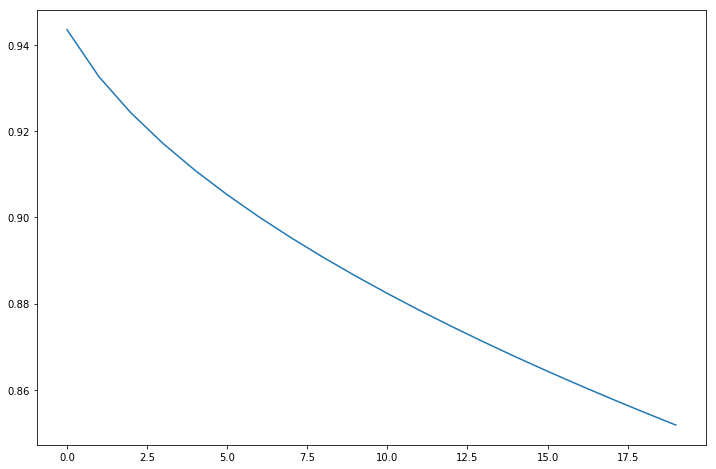

In [5]:
price = 0.97
prices = [getImpactPrice(price, 0.05*i) for i in range(1,21)]
# this looks okay.
plt.figure(figsize=(12, 8))
plt.plot(prices)

In [6]:
# to add the random component in the price
def addRandom(price):
    p = min(1, max(0.01, price + np.random.normal(0, 0.005)))
    return p

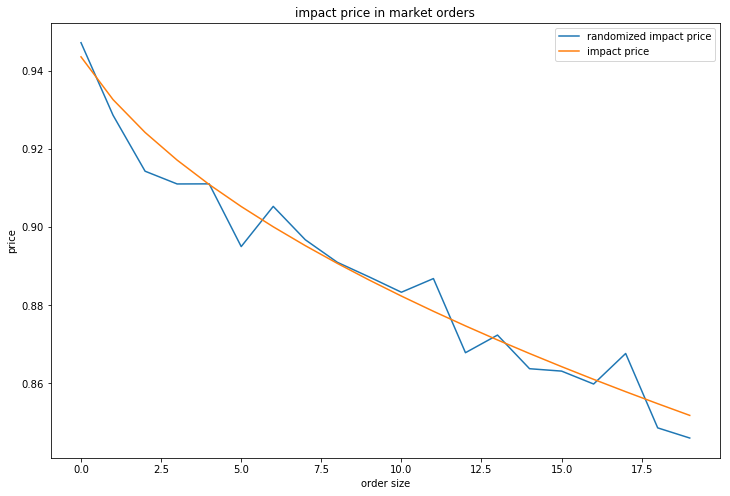

In [7]:
# this also looks okay
rp = [addRandom(p) for p in prices]
plt.figure(figsize=(12, 8))
plt.plot(rp, label='randomized impact price')
plt.plot(prices, label ='impact price')
plt.xlabel('order size')
plt.ylabel('price')
plt.title('impact price in market orders')
plt.legend()

In [10]:
def getDarkPrice(price):
    darkPrices = np.random.normal(0.005, 0.01, 100)
    dark = sum(darkPrices)/100.0
    #pdf = stats.norm.pdf(0.01, 0.01)
    darkPrice = max(0.01, price - dark)
    return darkPrice

In [11]:
# lets implement the parametric form of policy function as logistic regression, 
# since we want to apply order in between (0,1)

def getAction(state, param, t):
    '''param is 3d parameter parameter vector and state is 3d vector of state, it returns the value of softmax 
    function/logistic regression based on state and param'''
    featMarket = getMarketFeat(state, t)
    featDark = getDarkFeat(state, t)
    val = [0,0]
    val[0] = 1/(1+ np.exp(np.dot(param[0], featDark)))
    val[1] = 1/(1+np.exp(np.dot(param[1], featMarket)))
    return val


In [12]:
def getRewardState(state, action):
    '''it takes current state and action, returns next state and reward generated in this state'''
    newState = [0 for s in state]
    #print('action: ', action)
    price = getImpactPrice(state[0], action[1])
    reward = action[1]*price*state[1] #darkExec*darkPrice + (state[1] - darkExec)*action[1]*price
    remain = max(state[1]*(1-action[1]), 0)
    darkPrice = getDarkPrice(state[0])
    darkFrac = np.random.gumbel(state[2], beta, 100)
    darkExec = max(0, np.mean(darkFrac))
    rand = np.random.random()
    if rand < 0.8:
        darkExec = 0.0
    reward = reward + (darkExec*action[0]*remain)
    newState[0] = addRandom(price)
    newState[1] = max(remain*(1- darkExec*action[0]), 0)
    newState[2] = darkExec
    
    return (reward, newState)

In [13]:
# lets define function to calculate the state value function based on parameters of it
def getStateValue(state, param, t):
    stateFeat = getStateFeatures(state, t)
    value = np.dot(stateFeat, param)
    return value

In [14]:
# function to get the terminal reward
def getTerminalReward(state):
    ''' This function will return terminal reward based on terminal state provide'''
    price = getImpactPrice(state[0], state[1])
    reward = price*state[1]
    return reward

In [15]:
def getMarketFeat(state, t):
    featMarket = np.random.random(3)
    featMarket[0] = 0.11*(T-t+1)*(np.sqrt(state[0]*state[1]))
    featMarket[1] = 0.07*(T-t+1)*state[0]
    featMarket[2] = 0.18*(T-t+1)*state[1]*state[1]
    return featMarket

def getDarkFeat(state, t):
    featDark = np.random.random(3)
    featDark[0] = 0.18*(T-t+1)*(np.sqrt(state[0]*state[1]))
    featDark[1] = 0.12*(T-t+1)*state[2]
    featDark[2] = 0.32*(T-t+1)*state[1]*state[1]
    if t > 8:
        featDark[0] = 3.9*(T-t+1)*(np.sqrt(state[0]*state[1]))
        featDark[2] = 6.8*(T-t+1)*state[1]*state[1]
    return featDark

def getStateFeatures(state, t):
    feat = np.random.random(5)
    feat[0] = state[0]*state[1]
    feat[1] = state[0]*state[2]
    feat[2] = state[1]*state[1]
    feat[3] = state[0]*state[0]
    feat[4] = state[2]
    return feat

# implenting actor critic method, lets see if it converges or not
# we will consider that we have set of parameters for each time index
T = 20
#parameter set for state value function

theta = [np.random.random(5) for i in range(T-1)]
#parameter set for policy function
phi_market = [np.random.random(3) for i in range(T-1)]
phi_dark = [np.random.random(3) for i in range(T-1)]
# learning rate for policy function as well as value function is put to be 0.001 initially
alphaValue = 0.014
alphaMarket = 0.002
alphaDark = 0.001

# as general rule of thumb is to put lambda value as 0.9 in TD(lambda) algo, I would put the same here
lambbda = 0.97
beta = 0.02
it = 5000

In [16]:
# now lets implement the actor critic method here and see if it works or not
# let us take number of iterations as 10000 initially and then we will see later if it works
err = [[0 for i in range(it)] for j in range(T)]
N = 1
while N <= it:
    # generate the initial state and start state = [price, stocks, 1]
    state = [np.random.uniform(0.01, .99), 1.0, max(0, np.random.gumbel(0,beta))]
    t = 0
    z = np.random.random(5)
    while t < (T-1) and state[1] > 0.0000001:
        # get the action to apply based on the policy we have till now
        #print(phi_dark[t])
        action = getAction(state, [phi_dark[t], phi_market[t]], t+1)
        #random = np.random.random()
        #exploreDark = 1.0
        #exploreMarket = 1.0
        exploreMarket = np.random.normal(0, 0.08)
        exploreDark = np.random.normal(0, 0.01)
        action[0] = action[0] + exploreDark
        action[1] = action[1] + exploreMarket
        (reward, newState) = getRewardState(state, action)
        # based on above get the delta error value as below
        stateVal = getStateValue(state, theta[t], t+1)
        if t == T-2:
            delta = reward + getTerminalReward(newState) - stateVal
        else:
            delta = reward + getStateValue(newState, theta[t+1], t+2) - stateVal
        #now update the set of parameters that is theta and nu
        err[t][N-1] = delta
        z = np.add(np.multiply(lambbda, z), getStateFeatures(state, t+1))
        theta[t] = np.add(theta[t], np.multiply(alphaValue*delta, z))#np.multiply(alphaValue*delta, getStateFeatures(state, t+1)))
        phi_dark[t] = np.subtract(phi_dark[t], np.multiply(alphaDark*action[0]*(1-action[0])*(newState[2]-1)*action[0]*newState[0]*state[1], getDarkFeat(state, t+1)))
        phi_market[t] = np.subtract(phi_market[t], np.multiply((t/T)*alphaMarket*delta*action[1]*action[1]*(1-action[1])*newState[0]*state[1], getMarketFeat(state, t+1)))
        state = newState
        t = t + 1
    N = N + 1
print('learning completed')

learning completed


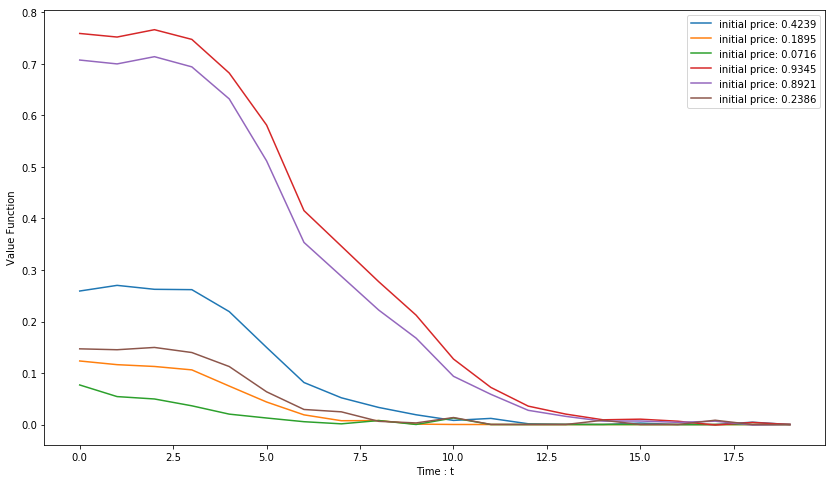

In [19]:
# after 10000 iterations
(values, actionD, actionM, prices, left) = actionValue()
(values1, actionD1, actionM1, prices1, left1) = actionValue()
(values2, actionD2, actionM2, prices2, left2) = actionValue()
(values3, actionD3, actionM3, prices3, left3) = actionValue()
(values4, actionD4, actionM4, prices4, left4) = actionValue()
(values5, actionD5, actionM5, prices5, left5) = actionValue()
plt.figure(figsize=(14,8))
plt.plot([i for i in range(T)], values, label = "initial price: " + "{0:.4f}".format(prices[0]))
plt.plot([i for i in range(T)], values1, label = "initial price: " + "{0:.4f}".format(prices1[0]))
plt.plot([i for i in range(T)], values2, label = "initial price: " + "{0:.4f}".format(prices2[0]))
plt.plot([i for i in range(T)], values3, label = "initial price: " + "{0:.4f}".format(prices3[0]))
plt.plot([i for i in range(T)], values4, label = "initial price: " + "{0:.4f}".format(prices4[0]))
plt.plot([i for i in range(T)], values5, label = "initial price: " + "{0:.4f}".format(prices5[0]))
plt.xlabel('Time : t')
#plt.title('Value Function')
plt.ylabel('Value Function')
plt.legend()
#print(values)


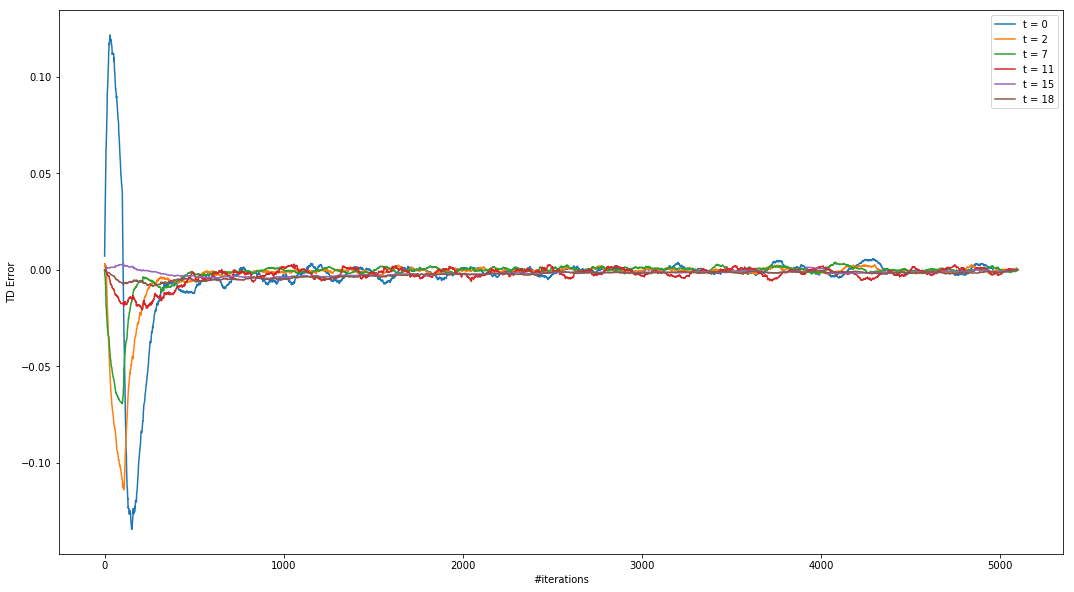

In [20]:
smoothed0 = np.convolve(err[0], np.ones(100)/100)
smoothed2 = np.convolve(err[2], np.ones(100)/100)
smoothed7 = np.convolve(err[7], np.ones(100)/100)
smoothed11 = np.convolve(err[11], np.ones(100)/100)
smoothed15 = np.convolve(err[15], np.ones(100)/100)
smoothed19 = np.convolve(err[18], np.ones(100)/100)
plt.figure(figsize=(18,10))
plt.plot(smoothed0, label='t = 0')
plt.plot(smoothed2, label='t = 2')
plt.plot(smoothed7, label='t = 7')
plt.plot(smoothed11, label='t = 11')
plt.plot(smoothed15, label='t = 15')
plt.plot(smoothed19, label='t = 18')
#plt.title('TD Error Plot')
plt.xlabel('#iterations')
plt.ylabel('TD Error')
plt.legend()

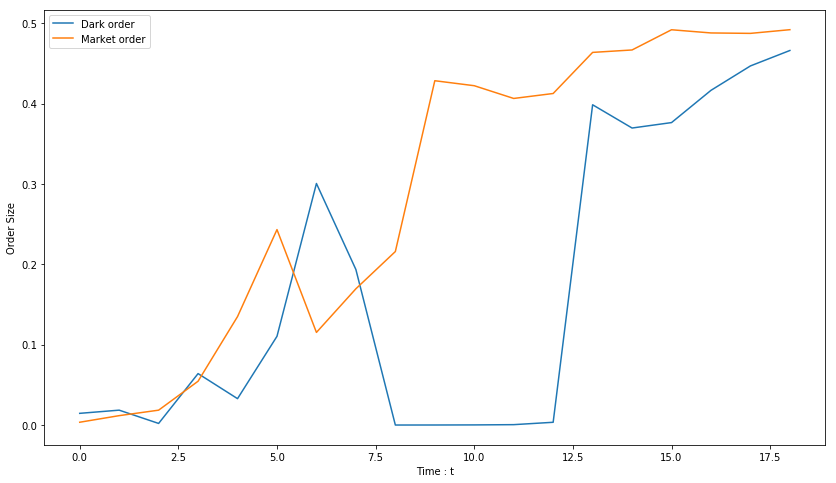

In [22]:
plt.figure(figsize=(14,8))
plt.plot(actionD3,  label ='Dark order')
plt.plot(actionM3,  label = 'Market order')
#plt.plot(left2,  label = 'Available Stock')
plt.xlabel('Time : t')
plt.ylabel('Order Size')
#plt.title('Orders Comparison')
plt.legend()
#print(actions)

In [18]:
# as per the above parameters let's check what is the output
def actionValue():
    darkAction = [0 for i in range(T-1)]
    marketAction = [0 for i in range(T-1)]
    val = [0 for i in range(T)]
    prices = [0 for i in range(T)]
    left_amount = [0 for i in range(T)]
    #for i in range(1000):
    value = 0.0
    s_t = [np.random.random(), 1.0, max(0, np.random.gumbel(0, beta))]
    #print(s_t)
    t = 0
    while t < T and s_t[1] > 0.000001:
        left_amount[t] = s_t[1]
        if t == T-1:
            #u_t = s_t[1]
            val[t] = getTerminalReward(s_t)
        else:
            #u_t0 = np.random.normal(5,5)
            (darkAction[t], marketAction[t]) =  getAction(s_t, [phi_dark[t], phi_market[t]], t+1)
            (reward, s) = getRewardState(s_t, [darkAction[t], marketAction[t]])
            val[t] = np.dot(getStateFeatures(s_t, t+1), theta[t])
        prices[t] = s_t[0]
        s_t = s
        t = t + 1
    #print(t)
    return (val, darkAction, marketAction, prices, left_amount)

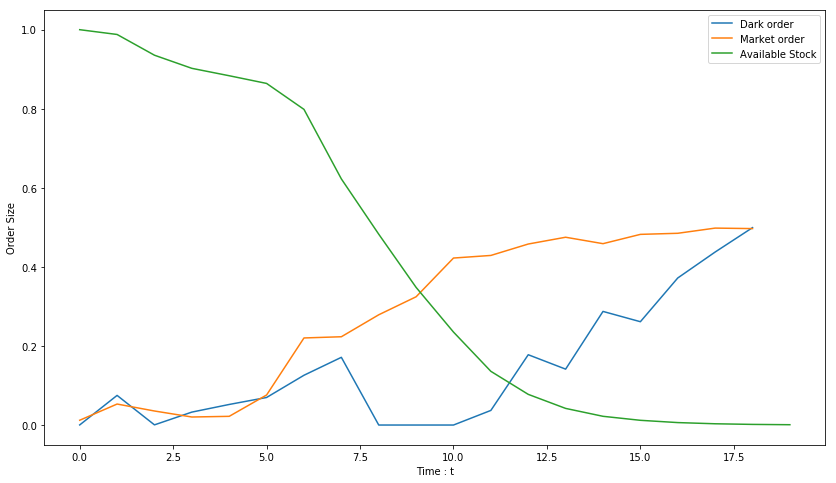

In [693]:
plt.figure(figsize=(14,8))
plt.plot(actionD2,  label ='Dark order')
plt.plot(actionM2,  label = 'Market order')
plt.plot(left2,  label = 'Available Stock')
plt.xlabel('Time : t')
plt.ylabel('Order Size')
#plt.title('Orders Comparison')
plt.legend()
#print(actions)

In [24]:
def calculateSplit(price):
    amount = 0.05
    value = 0.0
    for i in range(T):
        price = getImpactPrice(price, amount)
        value += price*amount
        #print(price)
        price = addRandom(price)
    return value

In [83]:
splitValues = np.random.random(100)
darkValues = np.random.random(100)
somePrices = np.random.random(100)
for i in range(len(splitValues)):
    state = [np.random.uniform(0.01, 0.99), 1.0, np.random.gumbel(0, beta)]
    #print(state[0])
    somePrices[i] = state[0]
    splitValues[i] = calculateSplit(state[0])
    darkValues[i] = np.dot(theta[0], getStateFeatures(state, 0))

#plt.figure(figsize=(12, 8))
#plt.plot([darkValues[i] - splitValues[i] for i in range(len(splitValues))], label='Difference')
#plt.plot(darkValues, label='Our Approach')
#plt.legend()
diff = np.subtract(darkValues, splitValues)
print(np.mean(diff))
stats.ttest_ind(darkValues, splitValues, equal_var=False)

0.0280837810258


Ttest_indResult(statistic=0.83388953147427203, pvalue=0.40535119271146636)

In [43]:
state = [np.random.random(), 1.0, np.random.gumbel(0, beta)]
calculateSplit(state[0])

0.41031036429836404

In [451]:
getImpactPrice(0.9456766928135039, 0.05)

0.78041585992060691

In [703]:
valueFile = open('valueF.csv', 'w')
for i in range(20):
    valueFile.write(str(i)+','+str(values[i]) + ','+ str(values1[i]) + ','+ str(values2[i]) + ','+ str(values3[i])+ ','+ str(values4[i])+ ','+ str(values5[i])+ '\n')
valueFile.close()

In [704]:
errorFile = open('errorF.csv', 'w')
for i in range(len(smoothed0)):
    errorFile.write(str(i)+','+str(smoothed0[i])+','+str(smoothed2[i])+','+str(smoothed7[i])+','+str(smoothed11[i])+','+str(smoothed15[i])+','+str(smoothed19[i])+'\n')
errorFile.close()

In [29]:
compFile = open('compF.csv', 'w')
for i in range(len(actionD)):
    compFile.write(str(i)+','+str(actionD[i])+','+str(actionM[i])+','+str(left[i])+'\n')
compFile.close()

In [709]:
leftFile = open('availF.csv', 'w')
for i in range(len(left)):
    leftFile.write(str(i)+','+str(left[i])+','+str(left1[i])+','+str(left2[i])+','+str(left3[i])+','+str(left4[i])+','+str(left5[i])+'\n')
leftFile.close()

In [706]:
marketFile = open('marketF.csv', 'w')
for i in range(len(actionD)):
    marketFile.write(str(i)+','+str(actionM[i])+','+str(actionM1[i])+','+str(actionM2[i])+','+str(actionM3[i])+','+str(actionM4[i])+','+str(actionM5[i])+'\n')
marketFile.close()

In [707]:
darkFile = open('darkF.csv', 'w')
for i in range(len(actionD)):
    darkFile.write(str(i)+','+str(actionD[i])+','+str(actionD1[i])+','+str(actionD2[i])+','+str(actionD3[i])+','+str(actionD4[i])+','+str(actionD5[i])+'\n')
darkFile.close()

In [708]:
darkFile = open('pricesF.csv', 'w')
for i in range(len(prices)):
    darkFile.write(str(i)+','+str(prices[i])+','+str(prices1[i])+','+str(prices2[i])+','+str(prices3[i])+','+str(prices4[i])+','+str(prices5[i])+'\n')
darkFile.close()

In [717]:
prices5[0]

0.9441532295412308

In [394]:
getImpactPrice(.99, 0.05)

0.9876240000000001

In [9]:
darkFile = open('price.csv', 'w')
for i in range(len(prices)):
    darkFile.write(str((i+1)/10)+','+str(prices[i])+','+str(addRandom(prices[i]))+'\n')
darkFile.close()

In [84]:
errorFile = open('errorSF.csv', 'w')
for i in range(1000):
    errorFile.write(str(i*10)+','+str(smoothed0[i])+','+str(smoothed2[i])+','+str(smoothed7[i])+','+str(smoothed11[i])+','+str(smoothed15[i])+','+str(smoothed19[i])+'\n')
errorFile.close()